In [1]:
import kwant
import pybinding as pb

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.keys()
plt.rcParams.update({'figure.figsize':(20,10),
                     'font.size':25})

from memory_profiler import memory_usage

In [2]:
def measure_pybinding(size, warmup=False, plot=False):
    def make_system(size, pot=0.2):
        t = 1
        a = 1
        p_length = size /10
        p_width = size /10

        def square_lattice(a, t):
            lat = pb.Lattice(a1=[a, 0], a2=[0, a])
            lat.add_sublattices(('A', [0, 0]))
            lat.add_hoppings(([0, 1], 'A', 'A', t),
                             ([1, 0], 'A', 'A', t))
            return lat

        def potential_barrier(v0, x0, y0):
            """Barrier height `v0` in eV with spatial position `-x0 <= x <= x0`"""
            @pb.onsite_energy_modifier(is_double=True)  # enable double-precision floating-point
            def function(energy, x, y):
                energy[np.logical_and(np.logical_and(-x0 <= x, x <= x0), np.logical_or(-y0 >= y, y >= y0))] = v0
                return energy
            return function    

        return pb.Model(square_lattice(a,t), potential_barrier(pot, p_length, p_width), pb.primitive(a1=int(size), a2=int(size*10)))



    with pb.utils.timed() as time:
        model = make_system(size)
        model.attach_lead(direction=-1, contact=pb.line([1, size*10], [1, -size*10]))
        model.attach_lead(direction=1, contact=pb.line([1, size*10], [1, -size*10]))

        h = model.hamiltonian
    if not warmup:
        print("  {:7} <-> atoms = {}, non-zeros = {}".format(str(time), h.shape[0], h.nnz))
    if plot:
        model.plot()
        plt.show()
    return time.elapsed


def measure_kwant(size, warmup=False, plot=False):
    def make_system(size, pot=0.2):
        t = 1
        a = 1
        W = size * 10
        L = size
        p_length = size / 10
        p_width = size / 10

        lat = kwant.lattice.square(a)
        syst = kwant.Builder()
        def onsite(site, pot):
            (x, y) = site.pos
            if (L - p_length) / 2 < x < (L + p_length) / 2:
                if y < (W - p_width) / 2 or y > (W + p_width) / 2:
                    return 4 * t + pot
            return 4 * t
        syst[(lat(x, y) for x in range(L) for y in range(W))] = onsite
        syst[lat.neighbors()] = -t
        
        sym_lead = kwant.TranslationalSymmetry((-a, 0))
        lead = kwant.Builder(sym_lead)
        lead[(lat(0, j) for j in range(W))] = 4 * t
        # hoppings in x-direction
        lead[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t
        # hoppings in y-directions
        lead[kwant.builder.HoppingKind((0, 1), lat, lat)] = -t
        syst.attach_lead(lead)
        syst.attach_lead(lead.reversed())

        return syst.finalized()

    
    
    with pb.utils.timed() as time:
        system = make_system(int(size))
        h = system.hamiltonian_submatrix(params=dict(pot=0.2), sparse=True)
    if not warmup:
        print("  {:7} <-> atoms = {}, non-zeros = {}".format(str(time), h.shape[0], h.nnz))
    if plot:
        kwant.plot(system)
        plt.show()
    return time.elapsed


def plot_time(sizes, times, label):
    plt.plot(sizes, times, label=label, marker='o', markersize=5, lw=2, zorder=10)
    plt.grid(True, which='major', color='gray', ls=':', alpha=0.5)
    plt.loglog()
    plt.xlabel("System size (number of atoms)")
    plt.ylabel("Build time (seconds)")
    plt.xlim(0.7 * min(sizes), 1.2 * max(sizes))
    pb.pltutils.despine()
    pb.pltutils.legend(loc='upper left', reverse=True)


def plot_memory(memory_profile, label):
    progress = np.linspace(0, 100, len(memory_profile))
    units = "MiB"
    if max(memory_profile) > 1024:
        memory_profile = np.array(memory_profile) / 1024
        units = "GiB"
    plt.plot(progress, memory_profile, lw=2, label=label, zorder=10)
    plt.grid(True, which='major', color='gray', ls=':', alpha=0.5)
    plt.xlabel("Build progress (%)")
    plt.ylabel("Memory ({})".format(units))
    pb.pltutils.despine()
    pb.pltutils.legend(loc='upper left', reverse=True)


def measure_and_plot(sizes, interval=0.02, plotting=False):
    """Measure build time and memory usage

    The list of `sizes` specifies the number atoms in the constructed systems.
    The `interval` is the memory usage sampling rate -- see `memory_profiler` package.

    The measurements are preceded by a short warmup run with a small system size. This
    takes care of submodule initialization so that it's not part of the measurement.
    """
    print("pybinding:")
    if plotting == False:
        measure_pybinding(1e2, warmup=True)
    pb_memory, pb_times = memory_usage(lambda: [measure_pybinding(n, plot=plotting) for n in sizes],
                                       interval, retval=True)
    print("\nkwant:")
    if plotting == False:
        measure_kwant(1e2, warmup=True)
    kwant_memory, kwant_times = memory_usage(lambda: [measure_kwant(n, plot=plotting) for n in sizes],
                                             interval, retval=True)

    plt.figure(figsize=(10, 10))
    plot_time(sizes, pb_times, label="pybinding")
    plot_time(sizes, kwant_times, label="kwant")
    plt.savefig("./figures/benchmark_runtime.png", dpi=300)
    
    plt.figure(figsize=(10, 10))
    plot_memory(pb_memory, label="pybinding")
    plot_memory(kwant_memory, label="kwant")
    
    plt.savefig("./figures/benchmark_memory.png", dpi=300)

pybinding:
  21ms    <-> atoms = 1000, non-zeros = 4077
  28ms    <-> atoms = 100000, non-zeros = 418401
  1.25s   <-> atoms = 10000000, non-zeros = 41948001

kwant:
  42ms    <-> atoms = 1000, non-zeros = 4780
  2.41s   <-> atoms = 100000, non-zeros = 497800
  4:21    <-> atoms = 10000000, non-zeros = 49978000


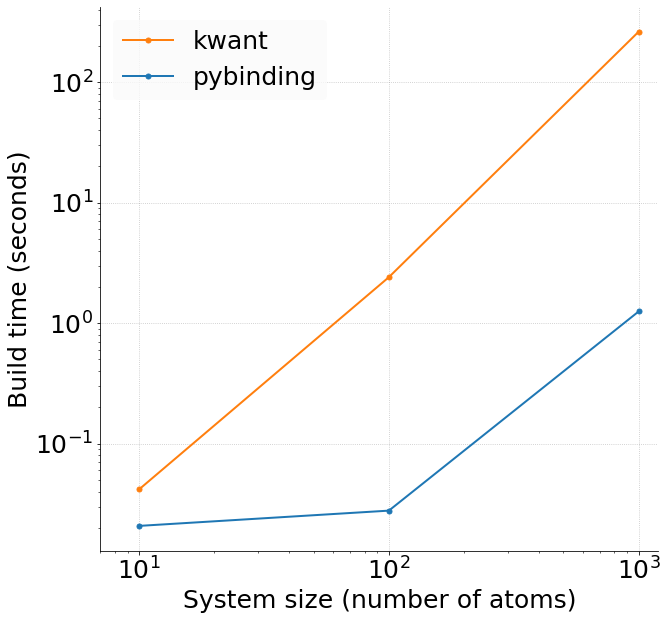

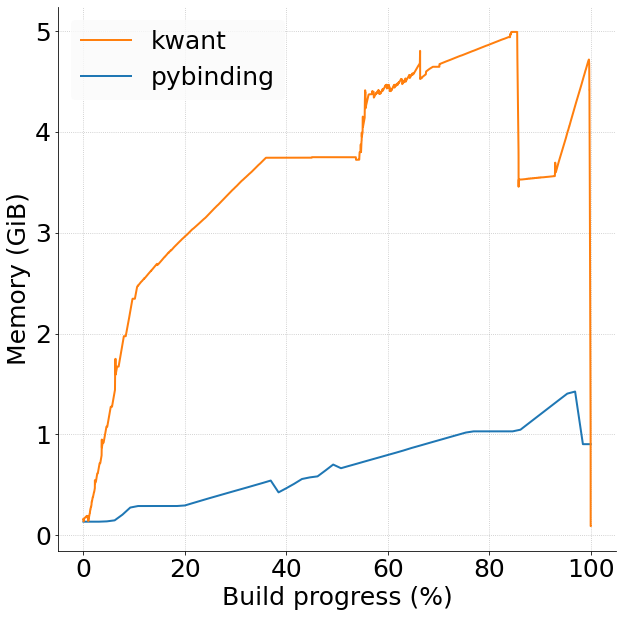

In [3]:
measure_and_plot(sizes=[10,100,1000], plotting=False)